In [ ]:
import math
import importlib
from typing import Literal

import torch
from torch import Tensor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ax import Client, RangeParameterConfig

from botorch.models import SingleTaskGP
from botorch.acquisition import qLogExpectedImprovement, qMaxValueEntropy

from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.priors import GammaPrior

from src.model_generation import get_full_strategy
from src import GPVisualiser, ax_helper
from src.ax_helper import get_guess_coords
import logging
from src.ax_helper import silence_ax_client

silence_ax_client


-0.0 -0.9874311636230129


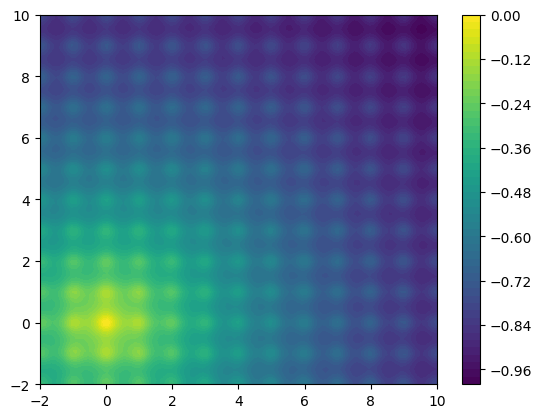

In [2]:
range_parameters = [
    RangeParameterConfig(
        name="x1", parameter_type="float", bounds=(-2, 10)
    ),
    RangeParameterConfig(
        name="x2", parameter_type="float", bounds=(-2, 10)
    )
]

metric_name = "response"
dim_names = ["x1", "x2"]


def test_function(x1, x2):
    # Ackley function (commonly used for optimization benchmarks)
    a = 20
    b = 0.2
    c = 2 * math.pi
    sum_sq = 0.5 * (x1**2 + x2**2)
    cos_comp = 0.5 * (math.cos(c * x1) + math.cos(c * x2))
    ackley_grid = -a * math.exp(-b * math.sqrt(sum_sq)) - math.exp(cos_comp) + a + math.exp(1)
    standardized = (ackley_grid-0.2434339681166695)/(19.3680592868830)
    return -standardized


import numpy as np
grid = np.linspace(-2, 10, 101)
x1_grid, x2_grid = np.meshgrid(grid, grid)
ackley_vals = np.array([test_function(x1, x2) for x1, x2 in zip(x1_grid.ravel(), x2_grid.ravel())]).reshape(x1_grid.shape)
ackley_vals
print(ackley_vals.max(), ackley_vals.min())


plt.contourf(x1_grid, x2_grid, ackley_vals, levels=60, cmap="viridis")
plt.colorbar()

# Sobol
The default initial parameter exploration strategy uses SOBOL algorithm:

### log param sobol:

In [3]:
import logging
import builtins

class SuppressInfoPrefix(logging.Filter):
    def filter(self, record):
        return not record.getMessage().startswith('[INFO')

# Create and register the filter globally (all loggers)
_filter = SuppressInfoPrefix()
root_logger = logging.getLogger()
root_logger.addFilter(_filter)
for handler in root_logger.handlers:
    handler.addFilter(_filter)

# Also add to any already-created loggers
for logger_name, lg in logging.root.manager.loggerDict.items():
    if isinstance(lg, logging.Logger):
        lg.addFilter(_filter)
        for h in lg.handlers:
            h.addFilter(_filter)

# Optional: suppress bare print() lines starting with '[INFO'
_original_print = builtins.print
def filtered_print(*args, **kwargs):
    if args and isinstance(args[0], str) and args[0].startswith('[INFO'):
        return
    _original_print(*args, **kwargs)

builtins.print = filtered_print


   trial_name         x0         x1
0         0_0  10.000000  10.000000
1         1_0  24.976105   1.320761
2         2_0   7.120260  23.928144
3         3_0   1.860226   5.007546
4         4_0  95.586531  63.184687
5         5_0  40.382861   7.604656
6         6_0   1.392842  41.557899
7         7_0   5.420469   1.989511
8         8_0  10.372459  15.903414
9         9_0  15.033359   3.315289
10       10_0   3.740374  95.329359
11       11_0   1.129974   1.442112
12       12_0  49.770724  21.939259
13       13_0  67.147246   2.999603
14       14_0   2.647698  10.536207
15       15_0   8.936104   6.967544
16       16_0  19.904077  45.408926
17       17_0  22.140379   5.682779
18       18_0   8.033273  55.614453
19       19_0   2.958524   2.662351
20       20_0  60.093834  11.883826
21       21_0  44.792831   1.751176
22       22_0   1.255525  18.047560
23       23_0   3.351251   3.776759
24       24_0  16.779394  83.772668
25       25_0  11.629931   2.257260
26       26_0   4.834332  14

<Axes: xlabel='x0', ylabel='x1'>

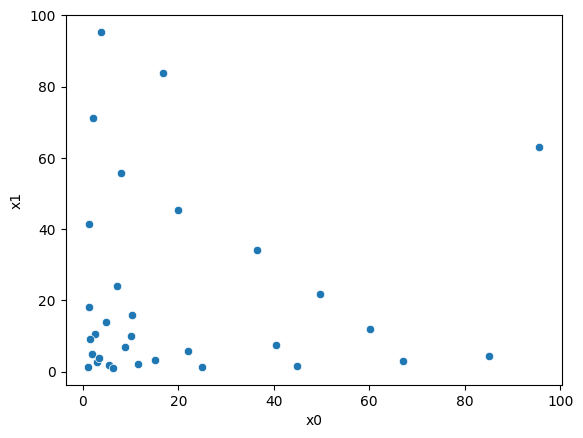

In [5]:

client = Client()
client.verbose_logging = False
#client.verbose_logging = False

client.configure_experiment(
    name="batch_bo_test",
    parameters=[
        RangeParameterConfig(
            name=f"x{i}",
            bounds=(1, 100),
            parameter_type="float",
            scaling = 'log',
        ) for i in range(len(dim_names))
    ],
)

client.configure_optimization(objective="-loss")
client.get_next_trials(max_trials=32)
coords = get_guess_coords(client)
print(coords)
sns.scatterplot(data=coords, x="x0", y="x1")

Low value oversampling is inline with logarithmic distribution.

**Considering that we expect overexpression to be optimal when compared to underexpression, Sobol should be run on a linear scale**.

### linear parameters sobol

<Axes: xlabel='x1', ylabel='x2'>

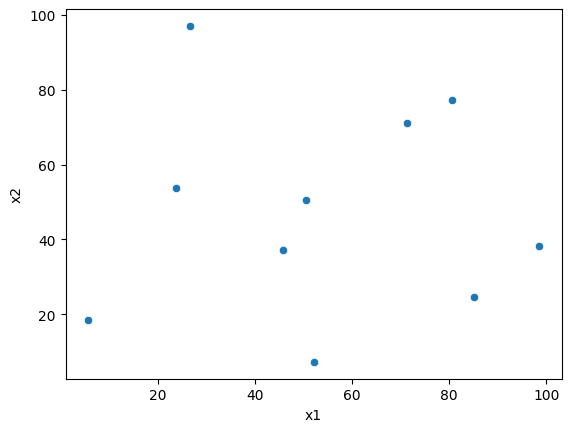

In [6]:
client = Client()

parameters=[
    RangeParameterConfig(
        name=dim,
        bounds=(1, 100),
        parameter_type="float",
        # scaling = 'log',
    ) for dim in dim_names
]


client.configure_experiment(
    name="batch_bo_test",
    parameters=parameters
)

client.configure_optimization(objective="response")
client.get_next_trials(max_trials=10)

coords = get_guess_coords(client)

sns.scatterplot(data=coords, x="x1", y="x2")

A nice and informative initial guess grid is formed

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\botorch\models\utils\assorted.py:270: InputDataWarning:

Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.



(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'GP along x1'}, xlabel='x1', ylabel='response'>,
        <Axes: title={'center': 'GP along x2'}, xlabel='x2', ylabel='response'>],
       dtype=object))

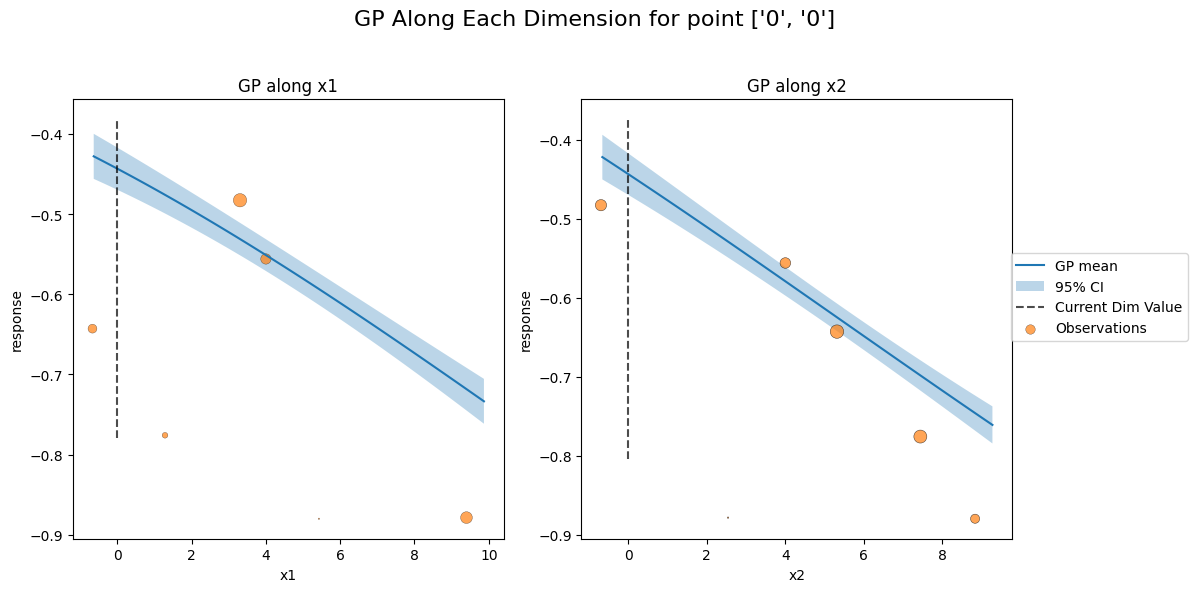

In [7]:
client = Client()

client.configure_experiment(parameters=range_parameters)


client.configure_optimization(objective=metric_name)

from src import ax_helper
importlib.reload(ax_helper)

batch_handler = ax_helper.BatchClientHandler(client, test_function, dim_names, metric_name, batch_size=6, range_params=range_parameters)
batch_handler.get_next_batch()
batch_handler.complete_all_pending()

df = ax_helper.get_obs_from_client(client, response_col='response')
plotter = GPVisualiser.GPVisualiserMatplotlib(SingleTaskGP, df, dim_names, 'response', parameters)
plotter.plot_all([0,0])

In [8]:
df

,trial_name,x1,x2,response
0,0_0,4.000000,4.000000,-0.556069
1,1_0,-0.669281,5.314188,-0.642979
2,2_0,9.399780,2.540886,-0.878599
3,3_0,5.427333,8.830131,-0.880024
4,4_0,3.303166,-0.693995,-0.482844
5,5_0,1.283909,7.436644,-0.775938


# Custom Botorch model

### Define the GP surrogate


MES (max value entropy search) should be the ideal choice for acquisition functions because:
* It can handle noise.
* Samples in a manner to best define the optimum.
    * Consequently, will rarely repeat exactly identical samplings.
* Has a cost/fidelity setting

In [9]:
client = Client()
generation_strategy = get_full_strategy(gp=SingleTaskGP, acqf_class=qLogExpectedImprovement)
client.configure_experiment(parameters=range_parameters)

client.set_generation_strategy(
    generation_strategy=generation_strategy,
)
client.configure_optimization(objective=metric_name)

from src import ax_helper
importlib.reload(ax_helper)

batch_handler = ax_helper.BatchClientHandler(client, test_function, dim_names, metric_name, batch_size=6, range_params=range_parameters)
batch_handler.get_next_batch()
batch_handler.complete_all_pending()

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\botorch\optim\optimize.py:753: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL

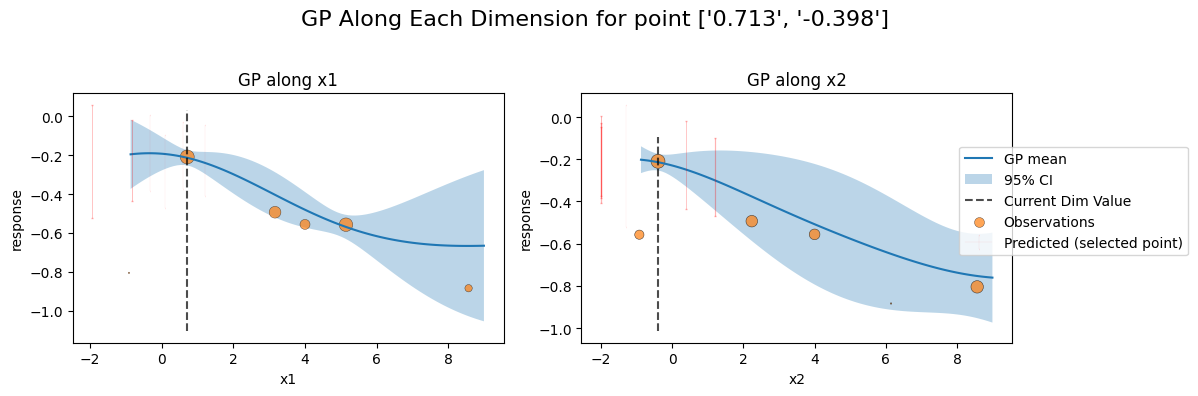

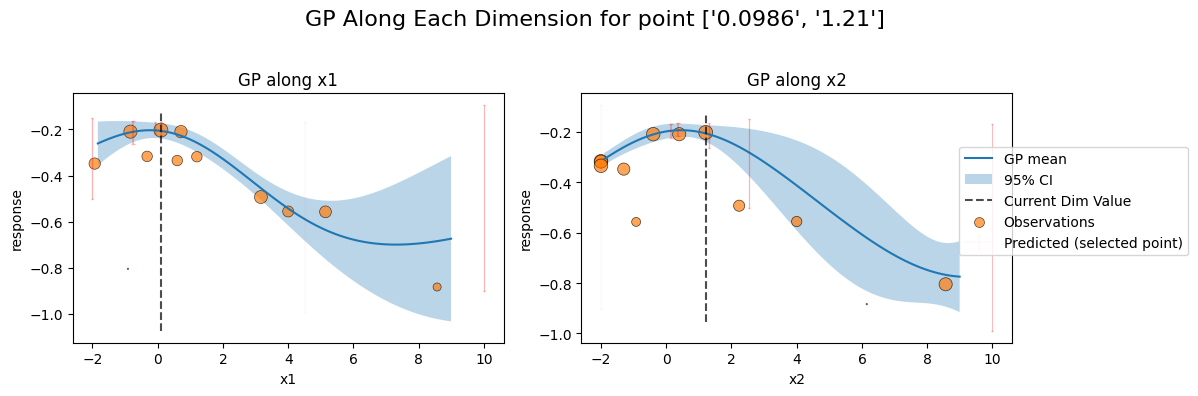

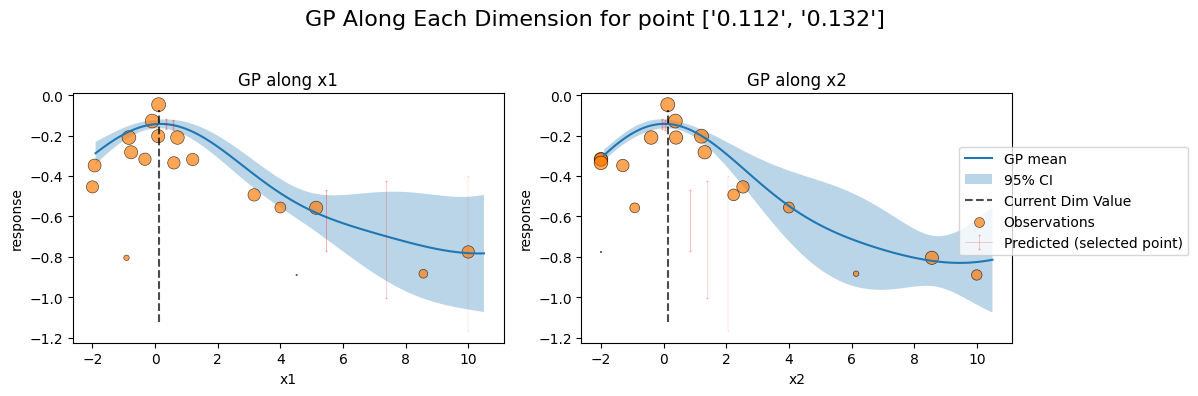

In [10]:
import matplotlib.pyplot as plt
for _ in range(3):
    batch_handler.get_next_batch()

    batch_handler.plot_GP(SingleTaskGP, figsize=(12, 4))
    batch_handler.complete_all_pending()

In [11]:
df

,trial_name,x1,x2,response
0,0_0,4.000000,4.000000,-0.556069
1,1_0,-0.669281,5.314188,-0.642979
2,2_0,9.399780,2.540886,-0.878599
3,3_0,5.427333,8.830131,-0.880024
4,4_0,3.303166,-0.693995,-0.482844
5,5_0,1.283909,7.436644,-0.775938


# Technical repeats
Knowing that real biological data posses significant significant noise, the model has to be robust enough to handle technical repeats

In [12]:
range_parameters = [
    RangeParameterConfig(
        name="x1", parameter_type="float", bounds=(-2, 10)
    )
]

metric_name = "response"
dim_names = ["x1"]

def test_function(x1):
    # Original: y = -((x1 - 2) ** 2) + 10  -> range on [-2,10] is [-54, 10]
    y = -((x1 - 2) ** 2) + 10
    return (y + 54) / 64  # scale to [0,1]


noise_fn = lambda x: x + np.random.normal(0, 1)

def plot_test():
    plt.plot(np.linspace(-2, 10, 100), [test_function(x) for x in np.linspace(-2, 10, 100)], color='black', label='True function')

In [13]:
class SequentialRuns:
    """Simulate sequential Bayesian optimization with batches and technical repeats.

    Initialized with a test (objective) function so different objectives can reuse the logic.
    """

    def __init__(self, test_fn, range_parameters, dim_names, metric_name):
        self.test_fn = test_fn
        self.range_parameters = range_parameters
        self.dim_names = dim_names
        self.metric_name = metric_name

    def run(
        self,
        gp,
        acqf_class=qLogExpectedImprovement,
        n_runs=10,
        batch_size=1,
        technical_repeats=1,
        noise_fn=None,
        plot_each=False,
    ):
        client = Client()
        client.configure_experiment(parameters=self.range_parameters)
        client.configure_optimization(objective=self.metric_name)

        if noise_fn is None:
            def noise_fn(x): return x

        generation_strategy = get_full_strategy(gp=gp, acqf_class=acqf_class)
        client.set_generation_strategy(generation_strategy=generation_strategy)

        handler = ax_helper.BatchClientHandler(
            client,
            self.test_fn,
            self.dim_names,
            self.metric_name,
            batch_size=batch_size,
            range_params=self.range_parameters,
        )
        handler.get_next_batch(batch_size)

        for _ in range(n_runs):
            handler.comp_noise_and_repeats(noise_fn=noise_fn, repeats=technical_repeats)
            handler.get_next_batch()
            if plot_each:
                handler.plot_GP(gp, figsize=(8, 4))
                plot_test()
                plt.show()
        return handler
SequentialRuns

__main__.SequentialRuns

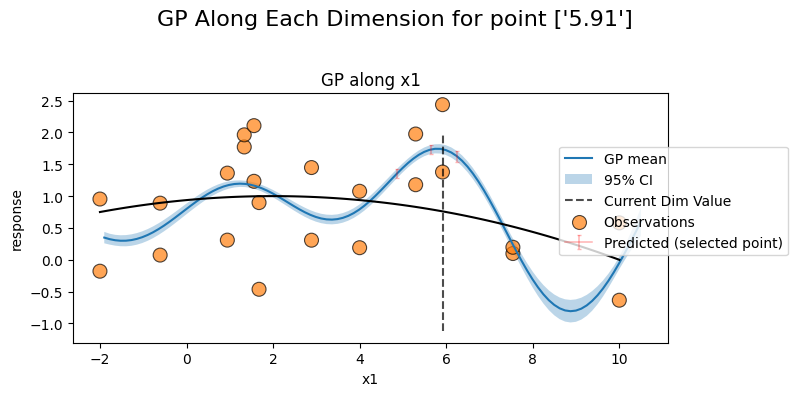

In [14]:
tester = SequentialRuns(test_function, range_parameters, dim_names, metric_name)

runs = tester.run(
    SingleTaskGP,
    n_runs=4,
    technical_repeats=2,
    batch_size=3,
    noise_fn=noise_fn,
    plot_each=False,
)
runs.plot_GP(SingleTaskGP, figsize=(8, 4))
plot_test()

* This simple Kernel is incapable of encompassing noise. Consequently, it overfits.
* Technical repeats slightly improve the situation, however they do not fix the problem.

### GP + noise

Simply adding a lot of noise, significantly improves the fit.
 

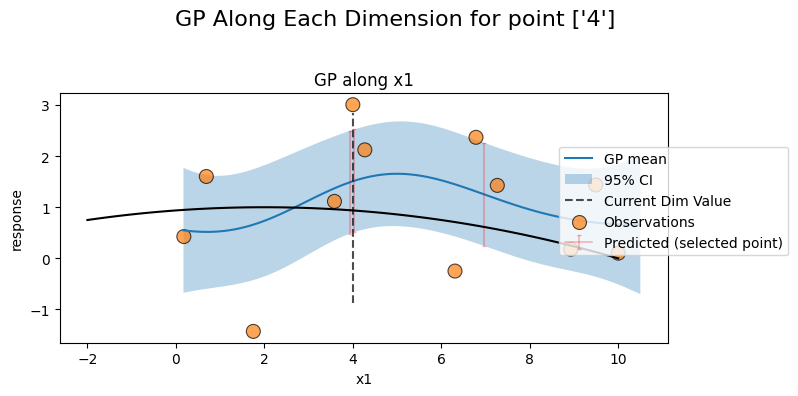

In [15]:
class GammaNoiseSGP(SingleTaskGP):
    """Just add a lot of assumed noise"""

    def __init__(
        self,
        train_X,
        train_Y,
        noise_concentration: float = 10,
        noise_rate: float = 10,
    ):

        likelihood = GaussianLikelihood(
            noise_prior=GammaPrior(noise_concentration, noise_rate)
        )

        super().__init__(
            train_X=train_X,
            train_Y=train_Y,
            likelihood=likelihood,
        )


runs = tester.run(
    GammaNoiseSGP,
    n_runs=4,
    technical_repeats=1,
    batch_size=3,
    noise_fn=noise_fn,
    plot_each=False,
).plot_GP(GammaNoiseSGP, figsize=(8, 4))


plot_test()

* Introducing a noise channel significantly improves fit performance, even if no technical repeats are provided to narrow down the mean.
However,a heteroscedastic, or at least technical repeat aware noise kernel would be preferable.

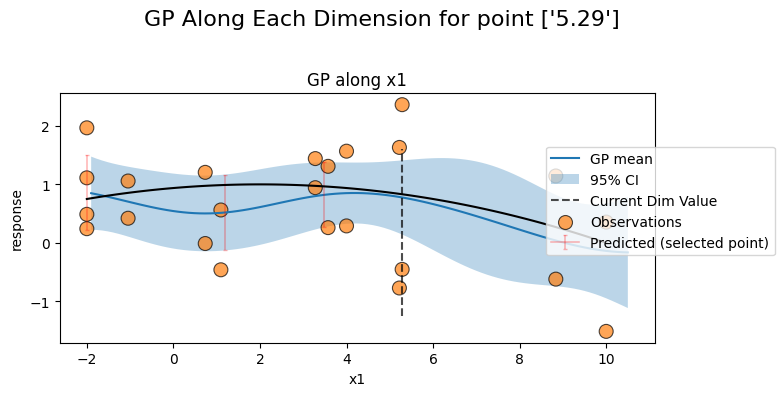

In [16]:
runs = tester.run(GammaNoiseSGP, n_runs=4, technical_repeats=2, batch_size=3, noise_fn=noise_fn, plot_each=False).plot_GP(GammaNoiseSGP, figsize=(8, 4))
plot_test()

It appears that technical repeats significantly improve noise resolution for the kernel, however, more quantitative tests are required.

# Quantification of Noise, technical repeats, and batch size.

6 dimensional hartman function is used for evaluation, due to its high dimensionality, multiple local optima, ridges and non-linear interactions.

In [17]:
# Hartmann 6D benchmark (domain: [0,1]^6). Standard form is for minimization.
# We return the negative so it can be used as a maximization objective (larger is better).
_h6_alpha = torch.tensor([1.0, 1.2, 3.0, 3.2])
_h6_A = torch.tensor([
    [10,  3, 17,  3,  1, 11],
    [ 0.05, 10, 17,  0.1, 8, 14],
    [ 3,  3.5, 1.7, 10, 17, 8],
    [17,  8,  0.05, 10, 0.1, 14],
])
_h6_P = 1e-4 * torch.tensor([
    [1312, 1696, 5569, 124, 8283, 5886],
    [2329, 4135, 8307, 3736, 1004, 9991],
    [2348, 1451, 3522, 2883, 3047, 6650],
    [4047, 8828, 8732, 5743, 1091, 381],
])

def hartmann6(x1, x2, x3, x4, x5, x6):
    """
    Hartmann-6 function (negated for maximization).
    Usage:
        hartmann6(x) where x is length-6 iterable in [0,1]
        or hartmann6(x1, x2, x3, x4, x5, x6)
    """
    args = (x1, x2, x3, x4, x5, x6)
    if len(args) == 1 and hasattr(args[0], "__len__"):
        x = torch.as_tensor(args[0], dtype=torch.float32)
    else:
        x = torch.as_tensor(args, dtype=torch.float32)
    if x.shape != (6,):
        raise ValueError("hartmann6 expects 6-dimensional input.")
    inner = torch.sum(_h6_A * (x - _h6_P) ** 2, dim=1)
    value = -torch.sum(_h6_alpha * torch.exp(-inner))  # standard (to be minimized)
    return -value  # negate so higher is better

# Quick check at known optimum (~minimum of original, hence maximum after negation)
_h6_x_opt = torch.tensor([0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573])
h_6_max = float(hartmann6(*_h6_x_opt))
h_6_max

3.416637659072876

In [18]:
hartmann6_range_parameters = [
    RangeParameterConfig(name=f"x{i+1}", parameter_type="float", bounds=(0.0, 1.0))
    for i in range(6)
]
dim_names_h6 = [rp.name for rp in hartmann6_range_parameters]

tester = SequentialRuns(hartmann6, hartmann6_range_parameters, dim_names_h6, metric_name)
tester


## Sequential runs no noise

In [ ]:
def noise_fn(x):
    return x
runs = tester.run(SingleTaskGP, n_runs=50, technical_repeats=1, batch_size=1, noise_fn=noise_fn, plot_each=False)


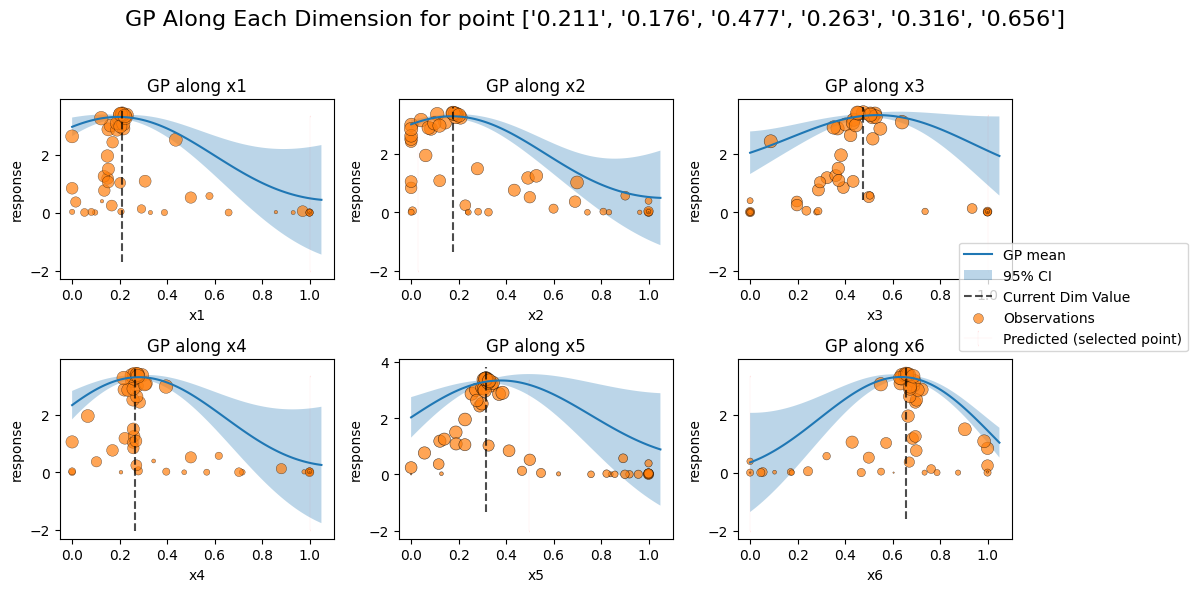

In [ ]:
runs.plot_GP(SingleTaskGP)

In [ ]:
def get_y_data(runs, dim_names, test_func):

    df = runs.get_batch_observations().sort_values(by='trial_index', ascending=True)
    df = df.groupby(["trial_index", *dim_names])['response'].mean().reset_index()

    df['y_true'] = df[dim_names_h6].apply(lambda r: float(test_func(*r.values)), axis=1)
    df['error'] = df['response'] - df['y_true']
    return df

def get_above_percentile(df, max_val, percentile = 0.95):
    cut_off = percentile*max_val
    df = df[(df['response']>cut_off) & (df['y_true']>cut_off)]
    return df
   
df = get_y_data(runs, dim_names_h6, hartmann6)
df = get_above_percentile(df, h_6_max)
df


,trial_index,x1,x2,x3,x4,x5,x6,response,y_true,error
23,23,0.201755,0.109917,0.525756,0.294032,0.305974,0.639228,3.364254,3.364254,0.0
27,27,0.122667,0.208111,0.515128,0.260988,0.343601,0.638021,3.251269,3.251269,0.0
28,28,0.229089,0.190878,0.506315,0.251668,0.321659,0.653196,3.361085,3.361085,0.0
29,29,0.210760,0.175775,0.476783,0.263324,0.315794,0.655817,3.401731,3.401731,0.0
30,30,0.224824,0.188060,0.528490,0.217417,0.324187,0.632398,3.267932,3.267932,0.0
31,31,0.212954,0.185616,0.456971,0.275923,0.314989,0.667665,3.382858,3.382858,0.0
33,33,0.203893,0.177618,0.452254,0.273657,0.312628,0.661212,3.392880,3.392880,0.0
36,36,0.221885,0.201931,0.506165,0.277418,0.328876,0.686721,3.326117,3.326117,0.0


In [ ]:
r_n_dict = {}
for technical_repeat in range(1, 9):
    for noise in np.linspace(0, 3.6, 10):
        def noise_fn(x): return x + np.random.normal(0, noise)
        runs = tester.run(SingleTaskGP, n_runs=10, technical_repeats=technical_repeat, batch_size=1, noise_fn=noise_fn, plot_each=False)
        df = get_y_data(runs, dim_names_h6, hartmann6)
        #df = get_above_percentile(df, h_6_max)
        r_n_dict[(technical_repeat, noise)] = len(df)

[INFO 09-24 11:14:30] ax.api.client: Generated new trial 0 with parameters {'x1': 0.5, 'x2': 0.5, 'x3': 0.5, 'x4': 0.5, 'x5': 0.5, 'x6': 0.5} using GenerationNode CenterOfSearchSpace.
[INFO 09-24 11:14:30] ax.api.client: Trial 0 marked COMPLETED.
[INFO 09-24 11:14:30] ax.api.client: Generated new trial 1 with parameters {'x1': 0.873326, 'x2': 0.48353, 'x3': 0.045567, 'x4': 0.105205, 'x5': 0.925002, 'x6': 0.766069} using GenerationNode Sobol.
[INFO 09-24 11:14:30] ax.api.client: Trial 1 marked COMPLETED.
[INFO 09-24 11:14:30] ax.api.client: Generated new trial 2 with parameters {'x1': 0.122249, 'x2': 0.697943, 'x3': 0.89434, 'x4': 0.92101, 'x5': 0.10712, 'x6': 0.346106} using GenerationNode Sobol.
[INFO 09-24 11:14:30] ax.api.client: Trial 2 marked COMPLETED.
[INFO 09-24 11:14:30] ax.api.client: Generated new trial 3 with parameters {'x1': 0.29372, 'x2': 0.028541, 'x3': 0.3506, 'x4': 0.252279, 'x5': 0.391483, 'x6': 0.13586} using GenerationNode Sobol.
[INFO 09-24 11:14:30] ax.api.client

Technical repeats: 1, Noise: 0.00, Points above 95th percentile: 0


[INFO 09-24 11:14:36] ax.api.client: Generated new trial 5 with parameters {'x1': 0.56562, 'x2': 0.606022, 'x3': 0.587862, 'x4': 0.231899, 'x5': 0.480647, 'x6': 0.567093} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:14:36] ax.api.client: Trial 5 marked COMPLETED.
[INFO 09-24 11:14:37] ax.api.client: Generated new trial 6 with parameters {'x1': 0.615867, 'x2': 0.392568, 'x3': 0.447182, 'x4': 0.703146, 'x5': 0.49506, 'x6': 0.539184} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:14:37] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-24 11:14:38] ax.api.client: Generated new trial 7 with parameters {'x1': 0.329057, 'x2': 0.569982, 'x3': 0.496915, 'x4': 0.43985, 'x5': 0.480325, 'x6': 0.445934} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:14:38] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-24 11:14:39] ax.api.client: Generated new trial 8 with parameters {'x1': 0.528796, 'x2': 0.496744, 'x3': 0.48978

Technical repeats: 1, Noise: 0.40, Points above 95th percentile: 0


[INFO 09-24 11:14:42] ax.api.client: Generated new trial 5 with parameters {'x1': 0.552359, 'x2': 0.905042, 'x3': 0.887462, 'x4': 0.864778, 'x5': 0.412719, 'x6': 0.66026} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:14:42] ax.api.client: Trial 5 marked COMPLETED.
[INFO 09-24 11:14:44] ax.api.client: Generated new trial 6 with parameters {'x1': 0.944425, 'x2': 0.842958, 'x3': 0.719426, 'x4': 0.914551, 'x5': 0.883453, 'x6': 0.179169} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:14:44] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-24 11:14:44] ax.api.client: Generated new trial 7 with parameters {'x1': 0.819667, 'x2': 0.711547, 'x3': 0.970616, 'x4': 0.975141, 'x5': 0.545938, 'x6': 0.390654} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:14:44] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-24 11:14:46] ax.api.client: Generated new trial 8 with parameters {'x1': 0.621231, 'x2': 0.832091, 'x3': 0.798

Technical repeats: 1, Noise: 0.80, Points above 95th percentile: 0


[INFO 09-24 11:14:50] ax.api.client: Generated new trial 5 with parameters {'x1': 0.608205, 'x2': 0.583291, 'x3': 0.369256, 'x4': 0.587167, 'x5': 0.439375, 'x6': 0.432697} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:14:50] ax.api.client: Trial 5 marked COMPLETED.
[INFO 09-24 11:14:51] ax.api.client: Generated new trial 6 with parameters {'x1': 0.590794, 'x2': 0.596707, 'x3': 0.758346, 'x4': 0.77561, 'x5': 0.541468, 'x6': 0.538806} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:14:51] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-24 11:14:51] ax.api.client: Generated new trial 7 with parameters {'x1': 0.528406, 'x2': 0.379557, 'x3': 0.166915, 'x4': 0.396897, 'x5': 0.487687, 'x6': 0.488862} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:14:51] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-24 11:14:52] ax.api.client: Generated new trial 8 with parameters {'x1': 0.553249, 'x2': 0.677761, 'x3': 0.581

Technical repeats: 1, Noise: 1.20, Points above 95th percentile: 0


[INFO 09-24 11:14:55] ax.api.client: Generated new trial 5 with parameters {'x1': 0.823316, 'x2': 0.180254, 'x3': 0.935541, 'x4': 0.052501, 'x5': 0.378554, 'x6': 0.740066} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:14:55] ax.api.client: Trial 5 marked COMPLETED.
[INFO 09-24 11:14:57] ax.api.client: Generated new trial 6 with parameters {'x1': 1.0, 'x2': 0.313478, 'x3': 0.80587, 'x4': 0.0, 'x5': 0.054102, 'x6': 0.934584} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:14:57] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-24 11:14:57] ax.api.client: Generated new trial 7 with parameters {'x1': 0.996163, 'x2': 0.410936, 'x3': 0.678772, 'x4': 0.250767, 'x5': 0.086781, 'x6': 0.858219} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:14:57] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-24 11:14:59] ax.api.client: Generated new trial 8 with parameters {'x1': 0.967016, 'x2': 0.351484, 'x3': 0.746957, 'x4':

Technical repeats: 1, Noise: 1.60, Points above 95th percentile: 0


[INFO 09-24 11:15:01] ax.api.client: Generated new trial 5 with parameters {'x1': 0.574611, 'x2': 0.825835, 'x3': 0.772509, 'x4': 0.812831, 'x5': 0.145301, 'x6': 0.550933} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:15:01] ax.api.client: Trial 5 marked COMPLETED.
[INFO 09-24 11:15:02] ax.api.client: Generated new trial 6 with parameters {'x1': 0.668059, 'x2': 1.0, 'x3': 0.971403, 'x4': 1.0, 'x5': 0.603029, 'x6': 0.983164} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:15:03] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-24 11:15:03] ax.api.client: Generated new trial 7 with parameters {'x1': 0.750068, 'x2': 0.875215, 'x3': 0.822194, 'x4': 0.814531, 'x5': 0.741575, 'x6': 0.970336} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:15:03] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-24 11:15:05] ax.api.client: Generated new trial 8 with parameters {'x1': 1.0, 'x2': 1.0, 'x3': 0.66846, 'x4': 0.850773,

Technical repeats: 1, Noise: 2.00, Points above 95th percentile: 0


[INFO 09-24 11:15:09] ax.api.client: Generated new trial 5 with parameters {'x1': 0.187154, 'x2': 0.494159, 'x3': 0.330031, 'x4': 0.483639, 'x5': 0.258852, 'x6': 0.068854} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:15:09] ax.api.client: Trial 5 marked COMPLETED.
[INFO 09-24 11:15:10] ax.api.client: Generated new trial 6 with parameters {'x1': 0.392858, 'x2': 0.912775, 'x3': 0.091609, 'x4': 0.377124, 'x5': 0.48285, 'x6': 0.066561} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:15:10] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-24 11:15:11] ax.api.client: Generated new trial 7 with parameters {'x1': 0.310378, 'x2': 0.751181, 'x3': 0.180465, 'x4': 0.415199, 'x5': 0.391739, 'x6': 0.06301} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:15:11] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-24 11:15:12] ax.api.client: Generated new trial 8 with parameters {'x1': 0.373441, 'x2': 0.716455, 'x3': 0.2588

Technical repeats: 1, Noise: 2.40, Points above 95th percentile: 0


[INFO 09-24 11:15:15] ax.api.client: Generated new trial 5 with parameters {'x1': 0.353644, 'x2': 0.897157, 'x3': 0.861564, 'x4': 0.682431, 'x5': 0.947627, 'x6': 0.21151} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:15:15] ax.api.client: Trial 5 marked COMPLETED.
[INFO 09-24 11:15:16] ax.api.client: Generated new trial 6 with parameters {'x1': 0.123643, 'x2': 1.0, 'x3': 1.0, 'x4': 1.0, 'x5': 1.0, 'x6': 0.131159} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:15:16] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-24 11:15:17] ax.api.client: Generated new trial 7 with parameters {'x1': 0.39965, 'x2': 0.942725, 'x3': 0.857144, 'x4': 0.586893, 'x5': 0.99081, 'x6': 0.153025} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:15:17] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-24 11:15:18] ax.api.client: Generated new trial 8 with parameters {'x1': 0.350522, 'x2': 0.833211, 'x3': 0.837986, 'x4': 0.730769, '

Technical repeats: 1, Noise: 2.80, Points above 95th percentile: 0


[INFO 09-24 11:15:20] ax.api.client: Generated new trial 5 with parameters {'x1': 0.407673, 'x2': 0.105298, 'x3': 0.951804, 'x4': 0.770612, 'x5': 1.0, 'x6': 0.906491} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:15:20] ax.api.client: Trial 5 marked COMPLETED.
[INFO 09-24 11:15:21] ax.api.client: Generated new trial 6 with parameters {'x1': 0.0, 'x2': 1.0, 'x3': 0.78166, 'x4': 1.0, 'x5': 1.0, 'x6': 1.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:15:21] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-24 11:15:22] ax.api.client: Generated new trial 7 with parameters {'x1': 0.09211, 'x2': 0.463009, 'x3': 0.887928, 'x4': 0.958135, 'x5': 0.542271, 'x6': 0.920768} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:15:22] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-24 11:15:23] ax.api.client: Generated new trial 8 with parameters {'x1': 0.0, 'x2': 0.386345, 'x3': 0.806166, 'x4': 1.0, 'x5': 0.8884, 'x6': 

Technical repeats: 1, Noise: 3.20, Points above 95th percentile: 0


[INFO 09-24 11:15:26] ax.api.client: Generated new trial 5 with parameters {'x1': 0.75965, 'x2': 0.529515, 'x3': 0.136981, 'x4': 0.526128, 'x5': 0.840507, 'x6': 0.876995} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:15:26] ax.api.client: Trial 5 marked COMPLETED.
[INFO 09-24 11:15:26] ax.api.client: Generated new trial 6 with parameters {'x1': 1.0, 'x2': 0.904325, 'x3': 0.210965, 'x4': 1.0, 'x5': 0.0, 'x6': 0.616785} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:15:26] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-24 11:15:27] ax.api.client: Generated new trial 7 with parameters {'x1': 0.423224, 'x2': 0.57181, 'x3': 0.202071, 'x4': 0.62137, 'x5': 0.229952, 'x6': 0.147717} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:15:27] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-24 11:15:28] ax.api.client: Generated new trial 8 with parameters {'x1': 1.0, 'x2': 0.44189, 'x3': 0.191739, 'x4': 0.787621, 'x

Technical repeats: 1, Noise: 3.60, Points above 95th percentile: 0


[INFO 09-24 11:15:31] ax.api.client: Generated new trial 6 with parameters {'x1': 0.373389, 'x2': 0.57599, 'x3': 0.298452, 'x4': 0.401391, 'x5': 0.466992, 'x6': 0.429528} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:15:31] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-24 11:15:31] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-24 11:15:31] ax.api.client: Generated new trial 8 with parameters {'x1': 0.434563, 'x2': 0.502155, 'x3': 0.057103, 'x4': 0.277602, 'x5': 0.421802, 'x6': 0.358198} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:15:31] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-24 11:15:31] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-24 11:15:32] ax.api.client: Generated new trial 10 with parameters {'x1': 0.126074, 'x2': 0.770705, 'x3': 0.230409, 'x4': 0.324487, 'x5': 0.495626, 'x6': 0.410328} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:15:32] ax.api.client: Trial 10 marked CO

Technical repeats: 2, Noise: 0.00, Points above 95th percentile: 0


[INFO 09-24 11:15:37] ax.api.client: Generated new trial 6 with parameters {'x1': 1.0, 'x2': 1.0, 'x3': 1.0, 'x4': 0.0, 'x5': 1.0, 'x6': 1.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:15:37] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-24 11:15:37] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-24 11:15:37] ax.api.client: Generated new trial 8 with parameters {'x1': 0.157942, 'x2': 0.632068, 'x3': 0.034701, 'x4': 0.0, 'x5': 0.274772, 'x6': 0.109633} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:15:37] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-24 11:15:37] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-24 11:15:38] ax.api.client: Generated new trial 10 with parameters {'x1': 0.239404, 'x2': 0.0, 'x3': 0.933106, 'x4': 0.668527, 'x5': 0.319058, 'x6': 0.303922} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:15:38] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:15:38] ax.api.c

Technical repeats: 2, Noise: 0.40, Points above 95th percentile: 0


[INFO 09-24 11:15:43] ax.api.client: Generated new trial 6 with parameters {'x1': 0.720026, 'x2': 0.475469, 'x3': 0.849205, 'x4': 0.219281, 'x5': 0.490712, 'x6': 0.195293} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:15:43] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-24 11:15:43] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-24 11:15:43] ax.api.client: Generated new trial 8 with parameters {'x1': 0.955276, 'x2': 0.624171, 'x3': 0.517443, 'x4': 0.813016, 'x5': 0.185006, 'x6': 0.313553} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:15:43] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-24 11:15:43] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-24 11:15:44] ax.api.client: Generated new trial 10 with parameters {'x1': 0.587032, 'x2': 0.932618, 'x3': 0.734892, 'x4': 0.066604, 'x5': 0.064699, 'x6': 0.808273} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:15:44] ax.api.client: Trial 10 marked C

Technical repeats: 2, Noise: 0.80, Points above 95th percentile: 0


[INFO 09-24 11:15:48] ax.api.client: Generated new trial 6 with parameters {'x1': 1.0, 'x2': 0.0, 'x3': 1.0, 'x4': 0.0, 'x5': 0.0, 'x6': 0.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:15:48] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-24 11:15:48] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-24 11:15:48] ax.api.client: Generated new trial 8 with parameters {'x1': 1.0, 'x2': 1.0, 'x3': 1.0, 'x4': 0.0, 'x5': 0.779, 'x6': 1.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:15:48] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-24 11:15:48] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-24 11:15:49] ax.api.client: Generated new trial 10 with parameters {'x1': 0.193977, 'x2': 0.296931, 'x3': 0.728084, 'x4': 0.0, 'x5': 0.089315, 'x6': 1.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:15:49] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:15:49] ax.api.client: Trial 11 marked COMPL

Technical repeats: 2, Noise: 1.20, Points above 95th percentile: 0


[INFO 09-24 11:15:55] ax.api.client: Generated new trial 6 with parameters {'x1': 0.518692, 'x2': 0.264455, 'x3': 0.0, 'x4': 0.716272, 'x5': 0.289286, 'x6': 0.872734} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:15:55] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-24 11:15:55] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-24 11:15:55] ax.api.client: Generated new trial 8 with parameters {'x1': 1.0, 'x2': 0.0, 'x3': 0.0, 'x4': 1.0, 'x5': 0.0, 'x6': 0.233257} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:15:55] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-24 11:15:55] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-24 11:15:56] ax.api.client: Generated new trial 10 with parameters {'x1': 0.172916, 'x2': 0.352934, 'x3': 0.0, 'x4': 0.947757, 'x5': 0.39134, 'x6': 1.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:15:56] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:15:56] ax.api.cl

Technical repeats: 2, Noise: 1.60, Points above 95th percentile: 0


[INFO 09-24 11:16:00] ax.api.client: Generated new trial 6 with parameters {'x1': 0.669567, 'x2': 0.404408, 'x3': 0.616667, 'x4': 0.0, 'x5': 0.666939, 'x6': 0.008075} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:16:00] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-24 11:16:00] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-24 11:16:01] ax.api.client: Generated new trial 8 with parameters {'x1': 0.0, 'x2': 0.284542, 'x3': 0.584913, 'x4': 0.0, 'x5': 0.333411, 'x6': 1.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:16:01] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-24 11:16:01] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-24 11:16:01] ax.api.client: Generated new trial 10 with parameters {'x1': 0.059718, 'x2': 1.0, 'x3': 0.0, 'x4': 0.424549, 'x5': 1.0, 'x6': 0.507021} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:16:01] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:16:01] ax.

Technical repeats: 2, Noise: 2.00, Points above 95th percentile: 0


[INFO 09-24 11:16:05] ax.api.client: Generated new trial 6 with parameters {'x1': 0.0, 'x2': 0.0, 'x3': 1.0, 'x4': 0.828995, 'x5': 0.0, 'x6': 1.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:16:05] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-24 11:16:05] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-24 11:16:06] ax.api.client: Generated new trial 8 with parameters {'x1': 0.0, 'x2': 0.0, 'x3': 0.0, 'x4': 0.0, 'x5': 0.0, 'x6': 1.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:16:06] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-24 11:16:06] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-24 11:16:06] ax.api.client: Generated new trial 10 with parameters {'x1': 1.0, 'x2': 0.0, 'x3': 1.0, 'x4': 1.0, 'x5': 0.0, 'x6': 1.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:16:06] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:16:06] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24

Technical repeats: 2, Noise: 2.40, Points above 95th percentile: 0


[INFO 09-24 11:16:10] ax.api.client: Generated new trial 6 with parameters {'x1': 0.296416, 'x2': 0.567414, 'x3': 0.434909, 'x4': 0.27017, 'x5': 0.739538, 'x6': 0.379684} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:16:10] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-24 11:16:10] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-24 11:16:11] ax.api.client: Generated new trial 8 with parameters {'x1': 0.60698, 'x2': 0.468892, 'x3': 0.537687, 'x4': 0.603345, 'x5': 0.393339, 'x6': 0.570445} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:16:11] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-24 11:16:11] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-24 11:16:11] ax.api.client: Generated new trial 10 with parameters {'x1': 0.027115, 'x2': 0.695825, 'x3': 0.562867, 'x4': 0.369698, 'x5': 0.457519, 'x6': 0.285683} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:16:11] ax.api.client: Trial 10 marked COM

Technical repeats: 2, Noise: 2.80, Points above 95th percentile: 0


[INFO 09-24 11:16:17] ax.api.client: Generated new trial 6 with parameters {'x1': 1.0, 'x2': 0.35641, 'x3': 0.0, 'x4': 1.0, 'x5': 0.780661, 'x6': 0.125893} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:16:17] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-24 11:16:17] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-24 11:16:18] ax.api.client: Generated new trial 8 with parameters {'x1': 1.0, 'x2': 0.581165, 'x3': 0.0, 'x4': 0.774835, 'x5': 0.34153, 'x6': 0.711868} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:16:18] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-24 11:16:18] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-24 11:16:19] ax.api.client: Generated new trial 10 with parameters {'x1': 1.0, 'x2': 0.480538, 'x3': 0.0, 'x4': 0.617779, 'x5': 0.465872, 'x6': 0.294991} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:16:19] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:16:19] ax.ap

Technical repeats: 2, Noise: 3.20, Points above 95th percentile: 0


[INFO 09-24 11:16:27] ax.api.client: Generated new trial 6 with parameters {'x1': 1.0, 'x2': 0.0, 'x3': 1.0, 'x4': 0.0, 'x5': 1.0, 'x6': 0.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:16:27] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-24 11:16:27] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-24 11:16:27] ax.api.client: Generated new trial 8 with parameters {'x1': 0.0, 'x2': 0.0, 'x3': 1.0, 'x4': 0.0, 'x5': 0.0, 'x6': 0.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:16:27] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-24 11:16:27] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-24 11:16:28] ax.api.client: Generated new trial 10 with parameters {'x1': 0.0, 'x2': 1.0, 'x3': 1.0, 'x4': 0.0, 'x5': 0.0, 'x6': 0.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:16:28] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:16:28] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:1

Technical repeats: 2, Noise: 3.60, Points above 95th percentile: 0


[INFO 09-24 11:16:31] ax.api.client: Generated new trial 6 with parameters {'x1': 0.441667, 'x2': 0.690412, 'x3': 0.496641, 'x4': 0.516998, 'x5': 0.34439, 'x6': 0.689038} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:16:31] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-24 11:16:31] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-24 11:16:31] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-24 11:16:31] ax.api.client: Generated new trial 9 with parameters {'x1': 0.639934, 'x2': 0.814791, 'x3': 0.759055, 'x4': 0.300434, 'x5': 0.449081, 'x6': 0.774245} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:16:31] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-24 11:16:31] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:16:31] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:16:32] ax.api.client: Generated new trial 12 with parameters {'x1': 0.358604, 'x2': 0.614207, 'x3': 0.37886, 'x4': 0.612693, 'x5': 0.313772, 'x6

Technical repeats: 3, Noise: 0.00, Points above 95th percentile: 0


[INFO 09-24 11:16:38] ax.api.client: Generated new trial 6 with parameters {'x1': 0.251299, 'x2': 0.278997, 'x3': 1.0, 'x4': 0.244791, 'x5': 0.301946, 'x6': 0.363157} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:16:38] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-24 11:16:38] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-24 11:16:38] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-24 11:16:39] ax.api.client: Generated new trial 9 with parameters {'x1': 0.991195, 'x2': 0.0, 'x3': 1.0, 'x4': 0.0, 'x5': 0.0, 'x6': 0.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:16:39] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-24 11:16:39] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:16:39] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:16:40] ax.api.client: Generated new trial 12 with parameters {'x1': 0.0, 'x2': 0.373902, 'x3': 1.0, 'x4': 0.165217, 'x5': 0.513832, 'x6': 0.887078} using GenerationNode Sing

Technical repeats: 3, Noise: 0.40, Points above 95th percentile: 0


[INFO 09-24 11:16:44] ax.api.client: Generated new trial 6 with parameters {'x1': 0.0, 'x2': 1.0, 'x3': 0.0, 'x4': 1.0, 'x5': 0.0, 'x6': 1.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:16:44] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-24 11:16:44] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-24 11:16:44] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-24 11:16:45] ax.api.client: Generated new trial 9 with parameters {'x1': 1.0, 'x2': 1.0, 'x3': 0.0, 'x4': 1.0, 'x5': 1.0, 'x6': 1.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:16:45] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-24 11:16:45] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:16:45] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:16:45] ax.api.client: Generated new trial 12 with parameters {'x1': 1.0, 'x2': 1.0, 'x3': 0.0, 'x4': 1.0, 'x5': 0.0, 'x6': 0.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:1

Technical repeats: 3, Noise: 0.80, Points above 95th percentile: 0


[INFO 09-24 11:16:49] ax.api.client: Generated new trial 6 with parameters {'x1': 0.77698, 'x2': 0.691503, 'x3': 0.065874, 'x4': 0.505413, 'x5': 0.582958, 'x6': 0.703071} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:16:49] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-24 11:16:49] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-24 11:16:49] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-24 11:16:50] ax.api.client: Generated new trial 9 with parameters {'x1': 0.861291, 'x2': 0.508532, 'x3': 0.691633, 'x4': 0.202632, 'x5': 0.805731, 'x6': 0.961344} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:16:50] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-24 11:16:50] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:16:50] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:16:50] ax.api.client: Generated new trial 12 with parameters {'x1': 0.540766, 'x2': 0.811858, 'x3': 0.0, 'x4': 0.858713, 'x5': 0.280072, 'x6': 0

Technical repeats: 3, Noise: 1.20, Points above 95th percentile: 0


[INFO 09-24 11:16:55] ax.api.client: Generated new trial 6 with parameters {'x1': 0.336378, 'x2': 0.370232, 'x3': 0.624995, 'x4': 0.788204, 'x5': 0.372663, 'x6': 0.690683} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:16:55] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-24 11:16:55] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-24 11:16:55] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-24 11:16:55] ax.api.client: Generated new trial 9 with parameters {'x1': 0.940901, 'x2': 0.223774, 'x3': 0.136509, 'x4': 0.959525, 'x5': 0.569284, 'x6': 0.097237} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:16:55] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-24 11:16:55] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:16:55] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:16:56] ax.api.client: Generated new trial 12 with parameters {'x1': 1.0, 'x2': 0.82716, 'x3': 0.0, 'x4': 1.0, 'x5': 0.098399, 'x6': 0.181243} u

Technical repeats: 3, Noise: 1.60, Points above 95th percentile: 0


[INFO 09-24 11:16:59] ax.api.client: Generated new trial 6 with parameters {'x1': 0.0, 'x2': 0.0, 'x3': 0.0, 'x4': 1.0, 'x5': 1.0, 'x6': 0.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:17:00] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-24 11:17:00] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-24 11:17:00] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-24 11:17:00] ax.api.client: Generated new trial 9 with parameters {'x1': 0.0, 'x2': 1.0, 'x3': 0.0, 'x4': 1.0, 'x5': 1.0, 'x6': 0.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:17:00] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-24 11:17:00] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:17:00] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:17:00] ax.api.client: Generated new trial 12 with parameters {'x1': 0.0, 'x2': 1.0, 'x3': 0.0, 'x4': 0.0, 'x5': 1.0, 'x6': 0.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:1

Technical repeats: 3, Noise: 2.00, Points above 95th percentile: 0


[INFO 09-24 11:17:04] ax.api.client: Generated new trial 6 with parameters {'x1': 0.406792, 'x2': 0.997654, 'x3': 0.405736, 'x4': 0.630571, 'x5': 0.800964, 'x6': 0.452625} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:17:04] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-24 11:17:04] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-24 11:17:04] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-24 11:17:04] ax.api.client: Generated new trial 9 with parameters {'x1': 0.521254, 'x2': 0.419894, 'x3': 0.433492, 'x4': 0.815447, 'x5': 0.957417, 'x6': 0.878394} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:17:04] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-24 11:17:04] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:17:04] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:17:05] ax.api.client: Generated new trial 12 with parameters {'x1': 0.297923, 'x2': 1.0, 'x3': 0.41787, 'x4': 0.303568, 'x5': 0.421866, 'x6': 0

Technical repeats: 3, Noise: 2.40, Points above 95th percentile: 0


[INFO 09-24 11:17:11] ax.api.client: Generated new trial 6 with parameters {'x1': 0.093048, 'x2': 0.46779, 'x3': 0.658531, 'x4': 0.945073, 'x5': 0.371428, 'x6': 0.251225} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:17:11] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-24 11:17:11] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-24 11:17:11] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-24 11:17:11] ax.api.client: Generated new trial 9 with parameters {'x1': 0.548974, 'x2': 0.890907, 'x3': 0.917239, 'x4': 0.425909, 'x5': 0.08437, 'x6': 0.416947} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:17:11] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-24 11:17:11] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:17:11] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:17:12] ax.api.client: Generated new trial 12 with parameters {'x1': 0.274891, 'x2': 0.0, 'x3': 0.017698, 'x4': 0.773006, 'x5': 0.992005, 'x6': 0.

Technical repeats: 3, Noise: 2.80, Points above 95th percentile: 0


[INFO 09-24 11:17:17] ax.api.client: Generated new trial 6 with parameters {'x1': 1.0, 'x2': 1.0, 'x3': 1.0, 'x4': 0.772951, 'x5': 0.0, 'x6': 1.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:17:17] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-24 11:17:17] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-24 11:17:17] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-24 11:17:18] ax.api.client: Generated new trial 9 with parameters {'x1': 1.0, 'x2': 1.0, 'x3': 1.0, 'x4': 0.0, 'x5': 0.863025, 'x6': 1.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:17:18] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-24 11:17:18] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:17:18] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:17:18] ax.api.client: Generated new trial 12 with parameters {'x1': 1.0, 'x2': 1.0, 'x3': 1.0, 'x4': 0.0, 'x5': 1.0, 'x6': 0.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 

Technical repeats: 3, Noise: 3.20, Points above 95th percentile: 0


[INFO 09-24 11:17:22] ax.api.client: Generated new trial 6 with parameters {'x1': 0.343692, 'x2': 1.0, 'x3': 1.0, 'x4': 1.0, 'x5': 1.0, 'x6': 1.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:17:22] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-24 11:17:22] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-24 11:17:22] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-24 11:17:23] ax.api.client: Generated new trial 9 with parameters {'x1': 0.938501, 'x2': 0.031269, 'x3': 1.0, 'x4': 1.0, 'x5': 0.238419, 'x6': 1.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:17:23] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-24 11:17:23] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:17:23] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:17:23] ax.api.client: Generated new trial 12 with parameters {'x1': 0.0, 'x2': 0.896359, 'x3': 0.192315, 'x4': 1.0, 'x5': 0.42984, 'x6': 0.591115} using GenerationNode SingleTaskGP+qL

Technical repeats: 3, Noise: 3.60, Points above 95th percentile: 0


[INFO 09-24 11:17:28] ax.api.client: Generated new trial 8 with parameters {'x1': 0.383814, 'x2': 0.557418, 'x3': 0.614418, 'x4': 0.492867, 'x5': 0.394955, 'x6': 0.667781} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:17:28] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-24 11:17:28] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-24 11:17:28] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:17:28] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:17:29] ax.api.client: Generated new trial 12 with parameters {'x1': 0.290255, 'x2': 0.603653, 'x3': 0.706553, 'x4': 0.487122, 'x5': 0.310367, 'x6': 0.802887} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:17:29] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-24 11:17:29] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-24 11:17:29] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:17:29] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:17:29] ax.ap

Technical repeats: 4, Noise: 0.00, Points above 95th percentile: 0


[INFO 09-24 11:17:37] ax.api.client: Generated new trial 8 with parameters {'x1': 1.0, 'x2': 0.0, 'x3': 1.0, 'x4': 0.0, 'x5': 0.0, 'x6': 1.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:17:37] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-24 11:17:37] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-24 11:17:37] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:17:37] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:17:38] ax.api.client: Generated new trial 12 with parameters {'x1': 0.0, 'x2': 1.0, 'x3': 1.0, 'x4': 0.0, 'x5': 0.0, 'x6': 0.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:17:38] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-24 11:17:38] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-24 11:17:38] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:17:38] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:17:39] ax.api.client: Generated new trial 16 with parameters {'x1': 1.0,

Technical repeats: 4, Noise: 0.40, Points above 95th percentile: 0


[INFO 09-24 11:17:43] ax.api.client: Generated new trial 8 with parameters {'x1': 0.253686, 'x2': 0.342722, 'x3': 0.445599, 'x4': 0.258592, 'x5': 0.867369, 'x6': 0.843542} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:17:43] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-24 11:17:43] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-24 11:17:43] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:17:43] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:17:44] ax.api.client: Generated new trial 12 with parameters {'x1': 0.210608, 'x2': 0.860338, 'x3': 0.660004, 'x4': 0.625705, 'x5': 0.291839, 'x6': 0.936781} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:17:44] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-24 11:17:44] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-24 11:17:44] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:17:44] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:17:45] ax.ap

Technical repeats: 4, Noise: 0.80, Points above 95th percentile: 0


[INFO 09-24 11:17:52] ax.api.client: Generated new trial 8 with parameters {'x1': 0.0, 'x2': 0.0, 'x3': 0.0, 'x4': 1.0, 'x5': 1.0, 'x6': 0.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:17:52] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-24 11:17:52] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-24 11:17:52] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:17:52] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:17:53] ax.api.client: Generated new trial 12 with parameters {'x1': 0.55285, 'x2': 1.0, 'x3': 1.0, 'x4': 0.967999, 'x5': 0.363664, 'x6': 1.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:17:53] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-24 11:17:53] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-24 11:17:53] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:17:53] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:17:54] ax.api.client: Generated new trial 16 with paramete

Technical repeats: 4, Noise: 1.20, Points above 95th percentile: 0


[INFO 09-24 11:18:00] ax.api.client: Generated new trial 8 with parameters {'x1': 1.0, 'x2': 0.0, 'x3': 1.0, 'x4': 1.0, 'x5': 0.0, 'x6': 0.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:18:00] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-24 11:18:00] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-24 11:18:00] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:18:00] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:18:00] ax.api.client: Generated new trial 12 with parameters {'x1': 1.0, 'x2': 1.0, 'x3': 1.0, 'x4': 1.0, 'x5': 1.0, 'x6': 0.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:18:00] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-24 11:18:00] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-24 11:18:00] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:18:00] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:18:01] ax.api.client: Generated new trial 16 with parameters {'x1': 0.0,

Technical repeats: 4, Noise: 1.60, Points above 95th percentile: 0


[INFO 09-24 11:18:05] ax.api.client: Generated new trial 8 with parameters {'x1': 0.0, 'x2': 1.0, 'x3': 0.0, 'x4': 0.0, 'x5': 1.0, 'x6': 1.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:18:05] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-24 11:18:05] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-24 11:18:05] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:18:05] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:18:06] ax.api.client: Generated new trial 12 with parameters {'x1': 0.881378, 'x2': 1.0, 'x3': 0.0, 'x4': 0.0, 'x5': 1.0, 'x6': 1.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:18:06] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-24 11:18:06] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-24 11:18:06] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:18:06] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:18:06] ax.api.client: Generated new trial 16 with parameters {'x1':

Technical repeats: 4, Noise: 2.00, Points above 95th percentile: 0


[INFO 09-24 11:18:12] ax.api.client: Generated new trial 8 with parameters {'x1': 0.150103, 'x2': 0.179332, 'x3': 0.0, 'x4': 1.0, 'x5': 0.0, 'x6': 0.551831} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:18:12] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-24 11:18:12] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-24 11:18:12] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:18:12] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:18:12] ax.api.client: Generated new trial 12 with parameters {'x1': 0.877439, 'x2': 0.845879, 'x3': 0.0, 'x4': 0.194326, 'x5': 0.19935, 'x6': 0.444067} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:18:12] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-24 11:18:12] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-24 11:18:12] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:18:12] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:18:13] ax.api.client: Generated n

Technical repeats: 4, Noise: 2.40, Points above 95th percentile: 0


[INFO 09-24 11:18:18] ax.api.client: Generated new trial 8 with parameters {'x1': 1.0, 'x2': 1.0, 'x3': 0.0, 'x4': 0.0, 'x5': 1.0, 'x6': 1.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:18:18] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-24 11:18:18] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-24 11:18:18] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:18:18] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:18:18] ax.api.client: Generated new trial 12 with parameters {'x1': 1.0, 'x2': 1.0, 'x3': 1.0, 'x4': 0.0, 'x5': 1.0, 'x6': 1.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:18:18] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-24 11:18:18] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-24 11:18:18] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:18:18] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:18:19] ax.api.client: Generated new trial 16 with parameters {'x1': 0.0,

Technical repeats: 4, Noise: 2.80, Points above 95th percentile: 0


[INFO 09-24 11:18:23] ax.api.client: Generated new trial 8 with parameters {'x1': 0.059001, 'x2': 1.0, 'x3': 0.466834, 'x4': 0.731883, 'x5': 1.0, 'x6': 0.952756} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:18:23] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-24 11:18:23] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-24 11:18:23] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:18:23] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:18:24] ax.api.client: Generated new trial 12 with parameters {'x1': 0.971972, 'x2': 0.82755, 'x3': 0.535524, 'x4': 0.251934, 'x5': 1.0, 'x6': 0.014871} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:18:24] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-24 11:18:24] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-24 11:18:24] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:18:24] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:18:25] ax.api.client: Genera

Technical repeats: 4, Noise: 3.20, Points above 95th percentile: 0


[INFO 09-24 11:18:29] ax.api.client: Generated new trial 8 with parameters {'x1': 0.0, 'x2': 1.0, 'x3': 0.0, 'x4': 0.0, 'x5': 1.0, 'x6': 0.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:18:29] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-24 11:18:29] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-24 11:18:29] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:18:29] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:18:30] ax.api.client: Generated new trial 12 with parameters {'x1': 0.19426, 'x2': 1.0, 'x3': 0.0, 'x4': 0.586104, 'x5': 0.059868, 'x6': 0.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:18:30] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-24 11:18:30] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-24 11:18:30] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:18:30] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:18:31] ax.api.client: Generated new trial 16 with paramete

Technical repeats: 4, Noise: 3.60, Points above 95th percentile: 0


[INFO 09-24 11:18:38] ax.api.client: Generated new trial 10 with parameters {'x1': 0.667558, 'x2': 0.551915, 'x3': 0.5916, 'x4': 0.541683, 'x5': 0.328994, 'x6': 0.49427} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:18:38] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:18:38] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:18:38] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-24 11:18:38] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-24 11:18:38] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:18:39] ax.api.client: Generated new trial 15 with parameters {'x1': 0.303258, 'x2': 0.367927, 'x3': 0.320948, 'x4': 0.49454, 'x5': 0.438061, 'x6': 0.400474} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:18:39] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:18:39] ax.api.client: Trial 16 marked COMPLETED.
[INFO 09-24 11:18:39] ax.api.client: Trial 17 marked COMPLETED.
[INFO 09-24 11:18:39] ax.api

Technical repeats: 5, Noise: 0.00, Points above 95th percentile: 0


[INFO 09-24 11:18:48] ax.api.client: Generated new trial 10 with parameters {'x1': 0.377787, 'x2': 0.678688, 'x3': 0.257707, 'x4': 0.604309, 'x5': 0.44541, 'x6': 0.587749} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:18:48] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:18:48] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:18:48] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-24 11:18:48] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-24 11:18:48] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:18:49] ax.api.client: Generated new trial 15 with parameters {'x1': 0.749172, 'x2': 0.216862, 'x3': 0.358404, 'x4': 0.534431, 'x5': 0.861352, 'x6': 0.507497} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:18:49] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:18:49] ax.api.client: Trial 16 marked COMPLETED.
[INFO 09-24 11:18:49] ax.api.client: Trial 17 marked COMPLETED.
[INFO 09-24 11:18:49] ax.

Technical repeats: 5, Noise: 0.40, Points above 95th percentile: 0


[INFO 09-24 11:18:59] ax.api.client: Generated new trial 10 with parameters {'x1': 0.096239, 'x2': 0.474466, 'x3': 0.445575, 'x4': 0.82936, 'x5': 0.878869, 'x6': 0.709824} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:18:59] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:18:59] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:18:59] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-24 11:18:59] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-24 11:18:59] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:19:00] ax.api.client: Generated new trial 15 with parameters {'x1': 0.233486, 'x2': 0.948173, 'x3': 0.303077, 'x4': 0.141495, 'x5': 0.367957, 'x6': 0.628836} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:19:00] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:19:00] ax.api.client: Trial 16 marked COMPLETED.
[INFO 09-24 11:19:00] ax.api.client: Trial 17 marked COMPLETED.
[INFO 09-24 11:19:00] ax.

Technical repeats: 5, Noise: 0.80, Points above 95th percentile: 0


[INFO 09-24 11:19:05] ax.api.client: Generated new trial 10 with parameters {'x1': 1.0, 'x2': 1.0, 'x3': 0.0, 'x4': 0.0, 'x5': 1.0, 'x6': 1.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:19:05] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:19:05] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:19:05] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-24 11:19:05] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-24 11:19:05] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:19:06] ax.api.client: Generated new trial 15 with parameters {'x1': 0.348072, 'x2': 0.0, 'x3': 0.42387, 'x4': 0.0, 'x5': 0.9219, 'x6': 1.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:19:06] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:19:06] ax.api.client: Trial 16 marked COMPLETED.
[INFO 09-24 11:19:06] ax.api.client: Trial 17 marked COMPLETED.
[INFO 09-24 11:19:06] ax.api.client: Trial 18 marked COMPLETED.
[INFO 09

Technical repeats: 5, Noise: 1.20, Points above 95th percentile: 0


[INFO 09-24 11:19:14] ax.api.client: Generated new trial 10 with parameters {'x1': 0.0, 'x2': 0.0, 'x3': 0.0, 'x4': 1.0, 'x5': 1.0, 'x6': 0.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:19:14] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:19:14] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:19:14] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-24 11:19:14] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-24 11:19:14] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:19:15] ax.api.client: Generated new trial 15 with parameters {'x1': 0.403014, 'x2': 1.0, 'x3': 1.0, 'x4': 0.0, 'x5': 1.0, 'x6': 0.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:19:15] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:19:15] ax.api.client: Trial 16 marked COMPLETED.
[INFO 09-24 11:19:15] ax.api.client: Trial 17 marked COMPLETED.
[INFO 09-24 11:19:15] ax.api.client: Trial 18 marked COMPLETED.
[INFO 09-24 11:

Technical repeats: 5, Noise: 1.60, Points above 95th percentile: 0


[INFO 09-24 11:19:20] ax.api.client: Generated new trial 10 with parameters {'x1': 0.0, 'x2': 0.0, 'x3': 0.0, 'x4': 0.0, 'x5': 1.0, 'x6': 0.064639} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:19:20] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:19:20] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:19:20] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-24 11:19:20] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-24 11:19:20] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:19:21] ax.api.client: Generated new trial 15 with parameters {'x1': 0.0, 'x2': 0.0, 'x3': 0.0, 'x4': 0.0, 'x5': 0.048519, 'x6': 1.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:19:21] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:19:21] ax.api.client: Trial 16 marked COMPLETED.
[INFO 09-24 11:19:21] ax.api.client: Trial 17 marked COMPLETED.
[INFO 09-24 11:19:21] ax.api.client: Trial 18 marked COMPLETED.
[INFO 09-2

Technical repeats: 5, Noise: 2.00, Points above 95th percentile: 0


[INFO 09-24 11:19:26] ax.api.client: Generated new trial 10 with parameters {'x1': 1.0, 'x2': 1.0, 'x3': 1.0, 'x4': 0.0, 'x5': 0.0, 'x6': 0.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:19:26] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:19:26] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:19:26] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-24 11:19:26] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-24 11:19:26] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:19:27] ax.api.client: Generated new trial 15 with parameters {'x1': 0.0, 'x2': 0.0, 'x3': 0.0, 'x4': 0.0, 'x5': 0.0, 'x6': 1.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:19:27] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:19:27] ax.api.client: Trial 16 marked COMPLETED.
[INFO 09-24 11:19:27] ax.api.client: Trial 17 marked COMPLETED.
[INFO 09-24 11:19:27] ax.api.client: Trial 18 marked COMPLETED.
[INFO 09-24 11:19:27

Technical repeats: 5, Noise: 2.40, Points above 95th percentile: 0


[INFO 09-24 11:19:31] ax.api.client: Generated new trial 10 with parameters {'x1': 0.0, 'x2': 0.876114, 'x3': 0.700912, 'x4': 1.0, 'x5': 1.0, 'x6': 0.200557} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:19:31] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:19:31] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:19:31] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-24 11:19:31] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-24 11:19:31] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:19:32] ax.api.client: Generated new trial 15 with parameters {'x1': 0.0, 'x2': 0.036593, 'x3': 0.252458, 'x4': 0.980792, 'x5': 0.495937, 'x6': 0.868886} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:19:32] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:19:32] ax.api.client: Trial 16 marked COMPLETED.
[INFO 09-24 11:19:32] ax.api.client: Trial 17 marked COMPLETED.
[INFO 09-24 11:19:32] ax.api.client: Trial 1

Technical repeats: 5, Noise: 2.80, Points above 95th percentile: 0


[INFO 09-24 11:19:39] ax.api.client: Generated new trial 10 with parameters {'x1': 0.0, 'x2': 0.0, 'x3': 1.0, 'x4': 1.0, 'x5': 0.972038, 'x6': 1.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:19:39] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:19:39] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:19:39] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-24 11:19:39] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-24 11:19:39] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:19:40] ax.api.client: Generated new trial 15 with parameters {'x1': 0.850187, 'x2': 0.026993, 'x3': 1.0, 'x4': 0.124579, 'x5': 0.0, 'x6': 0.466012} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:19:40] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:19:40] ax.api.client: Trial 16 marked COMPLETED.
[INFO 09-24 11:19:40] ax.api.client: Trial 17 marked COMPLETED.
[INFO 09-24 11:19:40] ax.api.client: Trial 18 marked COMPLE

Technical repeats: 5, Noise: 3.20, Points above 95th percentile: 0


[INFO 09-24 11:19:46] ax.api.client: Generated new trial 10 with parameters {'x1': 1.0, 'x2': 0.0, 'x3': 1.0, 'x4': 1.0, 'x5': 0.0, 'x6': 0.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:19:46] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-24 11:19:46] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-24 11:19:46] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-24 11:19:46] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-24 11:19:46] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:19:46] ax.api.client: Generated new trial 15 with parameters {'x1': 1.0, 'x2': 1.0, 'x3': 0.0, 'x4': 1.0, 'x5': 0.0, 'x6': 0.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:19:46] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:19:46] ax.api.client: Trial 16 marked COMPLETED.
[INFO 09-24 11:19:46] ax.api.client: Trial 17 marked COMPLETED.
[INFO 09-24 11:19:46] ax.api.client: Trial 18 marked COMPLETED.
[INFO 09-24 11:19:46

Technical repeats: 5, Noise: 3.60, Points above 95th percentile: 0


[INFO 09-24 11:19:50] ax.api.client: Generated new trial 12 with parameters {'x1': 0.468689, 'x2': 0.388527, 'x3': 0.527528, 'x4': 0.614857, 'x5': 0.384901, 'x6': 0.319244} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:19:50] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-24 11:19:50] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-24 11:19:50] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:19:50] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:19:50] ax.api.client: Trial 16 marked COMPLETED.
[INFO 09-24 11:19:50] ax.api.client: Trial 17 marked COMPLETED.
[INFO 09-24 11:19:52] ax.api.client: Generated new trial 18 with parameters {'x1': 0.377495, 'x2': 0.683257, 'x3': 0.221761, 'x4': 0.63665, 'x5': 0.475457, 'x6': 0.501251} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:19:52] ax.api.client: Trial 18 marked COMPLETED.
[INFO 09-24 11:19:52] ax.api.client: Trial 19 marked COMPLETED.
[INFO 09-24 11:19:52] ax.

Technical repeats: 6, Noise: 0.00, Points above 95th percentile: 0


[INFO 09-24 11:19:58] ax.api.client: Generated new trial 12 with parameters {'x1': 0.081634, 'x2': 1.0, 'x3': 0.0, 'x4': 0.185841, 'x5': 0.19746, 'x6': 0.766539} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:19:58] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-24 11:19:58] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-24 11:19:58] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:19:58] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:19:58] ax.api.client: Trial 16 marked COMPLETED.
[INFO 09-24 11:19:58] ax.api.client: Trial 17 marked COMPLETED.
[INFO 09-24 11:19:59] ax.api.client: Generated new trial 18 with parameters {'x1': 0.662946, 'x2': 0.723072, 'x3': 0.0, 'x4': 0.622511, 'x5': 0.617923, 'x6': 0.395971} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:19:59] ax.api.client: Trial 18 marked COMPLETED.
[INFO 09-24 11:19:59] ax.api.client: Trial 19 marked COMPLETED.
[INFO 09-24 11:19:59] ax.api.client: Tri

Technical repeats: 6, Noise: 0.40, Points above 95th percentile: 0


[INFO 09-24 11:20:07] ax.api.client: Generated new trial 12 with parameters {'x1': 0.833562, 'x2': 0.220556, 'x3': 0.182098, 'x4': 0.474788, 'x5': 0.629158, 'x6': 0.690779} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:20:07] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-24 11:20:07] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-24 11:20:07] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:20:07] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:20:07] ax.api.client: Trial 16 marked COMPLETED.
[INFO 09-24 11:20:07] ax.api.client: Trial 17 marked COMPLETED.
[INFO 09-24 11:20:07] ax.api.client: Generated new trial 18 with parameters {'x1': 0.476724, 'x2': 0.657816, 'x3': 0.801861, 'x4': 0.888658, 'x5': 0.745365, 'x6': 0.453957} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:20:07] ax.api.client: Trial 18 marked COMPLETED.
[INFO 09-24 11:20:07] ax.api.client: Trial 19 marked COMPLETED.
[INFO 09-24 11:20:07] ax

Technical repeats: 6, Noise: 0.80, Points above 95th percentile: 0


[INFO 09-24 11:20:13] ax.api.client: Generated new trial 12 with parameters {'x1': 0.398278, 'x2': 0.539637, 'x3': 0.839747, 'x4': 0.082193, 'x5': 0.731907, 'x6': 0.258311} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:20:13] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-24 11:20:13] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-24 11:20:13] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:20:13] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:20:13] ax.api.client: Trial 16 marked COMPLETED.
[INFO 09-24 11:20:13] ax.api.client: Trial 17 marked COMPLETED.
[INFO 09-24 11:20:13] ax.api.client: Generated new trial 18 with parameters {'x1': 0.120064, 'x2': 0.292277, 'x3': 0.0, 'x4': 0.11377, 'x5': 0.574152, 'x6': 1.4e-05} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:20:13] ax.api.client: Trial 18 marked COMPLETED.
[INFO 09-24 11:20:13] ax.api.client: Trial 19 marked COMPLETED.
[INFO 09-24 11:20:13] ax.api.cl

Technical repeats: 6, Noise: 1.20, Points above 95th percentile: 0


[INFO 09-24 11:20:18] ax.api.client: Generated new trial 12 with parameters {'x1': 0.05287, 'x2': 0.0, 'x3': 0.188925, 'x4': 0.895158, 'x5': 0.40002, 'x6': 0.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:20:18] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-24 11:20:18] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-24 11:20:18] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:20:18] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:20:18] ax.api.client: Trial 16 marked COMPLETED.
[INFO 09-24 11:20:18] ax.api.client: Trial 17 marked COMPLETED.
[INFO 09-24 11:20:19] ax.api.client: Generated new trial 18 with parameters {'x1': 1.0, 'x2': 0.0, 'x3': 0.105162, 'x4': 0.005418, 'x5': 0.580526, 'x6': 0.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:20:19] ax.api.client: Trial 18 marked COMPLETED.
[INFO 09-24 11:20:19] ax.api.client: Trial 19 marked COMPLETED.
[INFO 09-24 11:20:19] ax.api.client: Trial 20 marke

Technical repeats: 6, Noise: 1.60, Points above 95th percentile: 0


[INFO 09-24 11:20:27] ax.api.client: Generated new trial 12 with parameters {'x1': 0.256466, 'x2': 0.823091, 'x3': 0.788471, 'x4': 0.0488, 'x5': 0.0, 'x6': 0.118846} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:20:27] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-24 11:20:27] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-24 11:20:27] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:20:27] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:20:27] ax.api.client: Trial 16 marked COMPLETED.
[INFO 09-24 11:20:27] ax.api.client: Trial 17 marked COMPLETED.
[INFO 09-24 11:20:28] ax.api.client: Generated new trial 18 with parameters {'x1': 1.0, 'x2': 1.0, 'x3': 1.0, 'x4': 0.694129, 'x5': 0.0, 'x6': 0.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:20:28] ax.api.client: Trial 18 marked COMPLETED.
[INFO 09-24 11:20:28] ax.api.client: Trial 19 marked COMPLETED.
[INFO 09-24 11:20:28] ax.api.client: Trial 20 marked COM

Technical repeats: 6, Noise: 2.00, Points above 95th percentile: 0


[INFO 09-24 11:20:35] ax.api.client: Generated new trial 12 with parameters {'x1': 0.0, 'x2': 0.0, 'x3': 0.944076, 'x4': 0.0, 'x5': 0.0, 'x6': 0.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:20:35] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-24 11:20:35] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-24 11:20:35] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:20:35] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:20:35] ax.api.client: Trial 16 marked COMPLETED.
[INFO 09-24 11:20:35] ax.api.client: Trial 17 marked COMPLETED.
[INFO 09-24 11:20:36] ax.api.client: Generated new trial 18 with parameters {'x1': 1.0, 'x2': 0.0, 'x3': 1.0, 'x4': 0.0, 'x5': 1.0, 'x6': 0.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:20:36] ax.api.client: Trial 18 marked COMPLETED.
[INFO 09-24 11:20:36] ax.api.client: Trial 19 marked COMPLETED.
[INFO 09-24 11:20:36] ax.api.client: Trial 20 marked COMPLETED.
[INFO 09-24 11:

Technical repeats: 6, Noise: 2.40, Points above 95th percentile: 0


[INFO 09-24 11:20:43] ax.api.client: Generated new trial 12 with parameters {'x1': 0.0, 'x2': 0.0, 'x3': 1.0, 'x4': 0.0, 'x5': 1.0, 'x6': 0.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:20:43] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-24 11:20:43] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-24 11:20:43] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:20:43] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:20:43] ax.api.client: Trial 16 marked COMPLETED.
[INFO 09-24 11:20:43] ax.api.client: Trial 17 marked COMPLETED.
[INFO 09-24 11:20:43] ax.api.client: Generated new trial 18 with parameters {'x1': 0.0, 'x2': 1.0, 'x3': 1.0, 'x4': 0.0, 'x5': 1.0, 'x6': 0.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:20:43] ax.api.client: Trial 18 marked COMPLETED.
[INFO 09-24 11:20:43] ax.api.client: Trial 19 marked COMPLETED.
[INFO 09-24 11:20:43] ax.api.client: Trial 20 marked COMPLETED.
[INFO 09-24 11:20:43

Technical repeats: 6, Noise: 2.80, Points above 95th percentile: 0


[INFO 09-24 11:20:50] ax.api.client: Generated new trial 12 with parameters {'x1': 0.0, 'x2': 0.0, 'x3': 0.0, 'x4': 1.0, 'x5': 1.0, 'x6': 1.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:20:50] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-24 11:20:51] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-24 11:20:51] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:20:51] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:20:51] ax.api.client: Trial 16 marked COMPLETED.
[INFO 09-24 11:20:51] ax.api.client: Trial 17 marked COMPLETED.
[INFO 09-24 11:20:51] ax.api.client: Generated new trial 18 with parameters {'x1': 0.897826, 'x2': 0.99309, 'x3': 0.0, 'x4': 1.0, 'x5': 1.0, 'x6': 1.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:20:51] ax.api.client: Trial 18 marked COMPLETED.
[INFO 09-24 11:20:51] ax.api.client: Trial 19 marked COMPLETED.
[INFO 09-24 11:20:51] ax.api.client: Trial 20 marked COMPLETED.
[INFO 09-24

Technical repeats: 6, Noise: 3.20, Points above 95th percentile: 0


[INFO 09-24 11:20:57] ax.api.client: Generated new trial 12 with parameters {'x1': 0.0, 'x2': 1.0, 'x3': 1.0, 'x4': 1.0, 'x5': 1.0, 'x6': 1.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:20:57] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-24 11:20:57] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-24 11:20:57] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:20:57] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:20:57] ax.api.client: Trial 16 marked COMPLETED.
[INFO 09-24 11:20:57] ax.api.client: Trial 17 marked COMPLETED.
[INFO 09-24 11:20:58] ax.api.client: Generated new trial 18 with parameters {'x1': 1.0, 'x2': 0.0, 'x3': 0.0, 'x4': 0.0, 'x5': 1.0, 'x6': 1.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:20:58] ax.api.client: Trial 18 marked COMPLETED.
[INFO 09-24 11:20:58] ax.api.client: Trial 19 marked COMPLETED.
[INFO 09-24 11:20:58] ax.api.client: Trial 20 marked COMPLETED.
[INFO 09-24 11:20:58

Technical repeats: 6, Noise: 3.60, Points above 95th percentile: 0


[INFO 09-24 11:21:04] ax.api.client: Generated new trial 14 with parameters {'x1': 0.483072, 'x2': 0.376218, 'x3': 0.377477, 'x4': 0.380257, 'x5': 0.486812, 'x6': 0.330382} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:21:04] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:21:04] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:21:04] ax.api.client: Trial 16 marked COMPLETED.
[INFO 09-24 11:21:04] ax.api.client: Trial 17 marked COMPLETED.
[INFO 09-24 11:21:04] ax.api.client: Trial 18 marked COMPLETED.
[INFO 09-24 11:21:04] ax.api.client: Trial 19 marked COMPLETED.
[INFO 09-24 11:21:04] ax.api.client: Trial 20 marked COMPLETED.
[INFO 09-24 11:21:05] ax.api.client: Generated new trial 21 with parameters {'x1': 0.283551, 'x2': 0.347393, 'x3': 0.261817, 'x4': 0.479823, 'x5': 0.202745, 'x6': 0.494365} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:21:05] ax.api.client: Trial 21 marked COMPLETED.
[INFO 09-24 11:21:05] ax

Technical repeats: 7, Noise: 0.00, Points above 95th percentile: 0


[INFO 09-24 11:21:12] ax.api.client: Generated new trial 14 with parameters {'x1': 0.309689, 'x2': 0.849492, 'x3': 0.703116, 'x4': 0.289404, 'x5': 0.172652, 'x6': 0.702081} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:21:12] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-24 11:21:12] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-24 11:21:12] ax.api.client: Trial 16 marked COMPLETED.
[INFO 09-24 11:21:12] ax.api.client: Trial 17 marked COMPLETED.
[INFO 09-24 11:21:12] ax.api.client: Trial 18 marked COMPLETED.
[INFO 09-24 11:21:12] ax.api.client: Trial 19 marked COMPLETED.
[INFO 09-24 11:21:12] ax.api.client: Trial 20 marked COMPLETED.
[INFO 09-24 11:21:12] ax.api.client: Generated new trial 21 with parameters {'x1': 0.856886, 'x2': 0.504377, 'x3': 0.819221, 'x4': 0.058641, 'x5': 0.250289, 'x6': 0.181099} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-24 11:21:12] ax.api.client: Trial 21 marked COMPLETED.
[INFO 09-24 11:21:12] ax

KeyboardInterrupt: 